In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import torch
from torchvision.ops import nms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# === 1. Load mô hình YOLO đã fine-tune ===
model = YOLO('/kaggle/input/best-pt/best.pt')

# === 2. Đọc ảnh ===
img_path = '/kaggle/input/picture-1-2/Pic_1_2.jpg'
image_bgr = cv2.imread(img_path)
original = image_bgr.copy()

# === 3. TÁCH MÀU HẠT VÀ LOẠI NỀN ĐỎ ===
hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Mask giữ màu hạt (vàng cam và hồng nhạt)
lower1 = np.array([5, 40, 80])
upper1 = np.array([25, 255, 255])
lower2 = np.array([0, 30, 70])
upper2 = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
mask = cv2.bitwise_or(mask1, mask2)

# Mask nền đỏ nhạt chìm để loại bỏ
lower_redbg = np.array([0, 20, 50])
upper_redbg = np.array([5, 120, 150])
mask_redbg = cv2.inRange(hsv, lower_redbg, upper_redbg)

# Loại vùng đỏ ra khỏi mask
mask = cv2.bitwise_and(mask, cv2.bitwise_not(mask_redbg))

# Morphology
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.dilate(mask, kernel, iterations=1)

# Áp mask để giữ lại vùng chứa hạt
image_bgr = cv2.bitwise_and(image_bgr, image_bgr, mask=mask)

# === 4. TIỀN XỬ LÝ CHÓI, GAMMA, SHARP ===
blurred = cv2.GaussianBlur(image_bgr, (3, 3), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
gray_mean = np.mean(v)

if gray_mean > 50:
    v[v > 180] = 250
    s = cv2.add(s, 30)
    v = cv2.subtract(v, 20)
else:
    v[v > 230] = 300

hsv = cv2.merge((h, s, v))
enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def adjust_gamma(img, gamma=1.3):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

enhanced = adjust_gamma(enhanced, gamma=1.3)
sharp = cv2.addWeighted(enhanced, 1.5, cv2.GaussianBlur(enhanced, (0, 0), 3), -0.5, 0)

# === 5. PAD ẢNH ===
pad = 160
sharp_padded = cv2.copyMakeBorder(sharp, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)

# === 6. CHIA TILE VÀ DỰ ĐOÁN ===
H, W = sharp_padded.shape[:2]
tile_size = 896
stride = 512
all_boxes = []
all_scores = []

for y in range(0, H, stride):
    for x in range(0, W, stride):
        tile = sharp_padded[y:y+tile_size, x:x+tile_size]
        if tile.shape[0] < 100 or tile.shape[1] < 100:
            continue

        results = model(tile, conf=0.1, max_det=700, imgsz=tile_size)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()

        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            area = w * h
            ratio = max(w / h, h / w)
            if area < 100 or area > 4000 or ratio > 3.0:
                continue
            all_boxes.append([x1 + x - pad, y1 + y - pad, x2 + x - pad, y2 + y - pad])
            all_scores.append(score)

# === 7. NMS + LOẠI BOX GẦN MÉP ẢNH ===
image_height, image_width = original.shape[:2]
all_boxes = torch.tensor(all_boxes).float()
all_scores = torch.tensor(all_scores).float()
keep = nms(all_boxes, all_scores, iou_threshold=0.15)

filtered_boxes = []
for i in keep:
    x1, y1, x2, y2 = all_boxes[i].tolist()
    score = all_scores[i].item()
    if (x2 > image_width - 12 or y2 > image_height - 12) and score < 0.4:
        continue
    filtered_boxes.append([x1, y1, x2, y2])

final_boxes = torch.tensor(filtered_boxes)

# === 8. VẼ KẾT QUẢ ===
im_pil = Image.fromarray(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(im_pil)
for box in final_boxes:
    x1, y1, x2, y2 = box.tolist()
    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

# === 9. LƯU VÀ HIỂN THỊ ẢNH ===
output_path = "/kaggle/working/detected_result_2.jpg"
im_pil.save(output_path)
print(f"📸 Ảnh đã lưu tại: {output_path}")
print("⬇ Bạn có thể tải ảnh từ phần 'Output' ở thanh bên phải của Kaggle")

plt.figure(figsize=(10, 10))
plt.imshow(im_pil)
plt.title(f"✅ Số lượng hạt: {len(final_boxes)}", fontsize=16)
plt.axis('off')
plt.show()


ModuleNotFoundError: No module named 'ultralytics'


0: 896x896 197 F_BuenEstado - v1 2024-03-02 12-24pms, 2783.8ms
Speed: 4.4ms preprocess, 2783.8ms inference, 4.1ms postprocess per image at shape (1, 3, 896, 896)

0: 896x896 278 F_BuenEstado - v1 2024-03-02 12-24pms, 2788.8ms
Speed: 4.0ms preprocess, 2788.8ms inference, 5.4ms postprocess per image at shape (1, 3, 896, 896)

0: 896x896 293 F_BuenEstado - v1 2024-03-02 12-24pms, 2781.4ms
Speed: 4.4ms preprocess, 2781.4ms inference, 5.5ms postprocess per image at shape (1, 3, 896, 896)

0: 896x608 170 F_BuenEstado - v1 2024-03-02 12-24pms, 1494.1ms
Speed: 2.9ms preprocess, 1494.1ms inference, 2.4ms postprocess per image at shape (1, 3, 896, 608)

0: 896x896 241 F_BuenEstado - v1 2024-03-02 12-24pms, 2799.3ms
Speed: 4.3ms preprocess, 2799.3ms inference, 3.5ms postprocess per image at shape (1, 3, 896, 896)

0: 896x896 287 F_BuenEstado - v1 2024-03-02 12-24pms, 2750.6ms
Speed: 4.0ms preprocess, 2750.6ms inference, 4.3ms postprocess per image at shape (1, 3, 896, 896)

0: 896x896 269 F_Buen

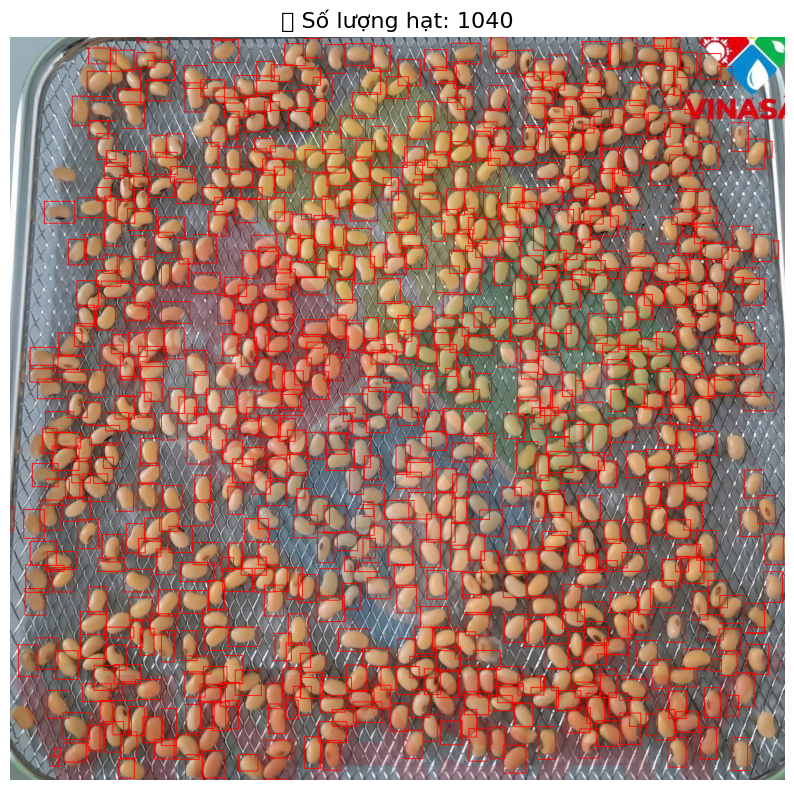

In [15]:
from ultralytics import YOLO
import cv2
import numpy as np
import torch
from torchvision.ops import nms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# === 1. Load mô hình YOLO đã fine-tune ===
model = YOLO('/kaggle/input/best-pt/best.pt')

# === 2. Đọc ảnh ===
img_path = '/kaggle/input/picture-2-4/Pic_2_4.jpg'
image_bgr = cv2.imread(img_path)
original = image_bgr.copy()

# === 3. TĂNG TƯƠNG PHẢN CHO VÙNG NỀN ĐỎ ===
# Cắt vùng nền đỏ (tọa độ bạn cho)
x1, y1, x2, y2 = 0, 1251, 1189, 1548
red_zone = image_bgr[y1:y2, x1:x2]

# Chuyển LAB và tăng tương phản bằng CLAHE
lab = cv2.cvtColor(red_zone, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
lab_clahe = cv2.merge((cl, a, b))
red_zone_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# Dán lại vùng đã xử lý vào ảnh
image_bgr[y1:y2, x1:x2] = red_zone_enhanced

# === 4. TÁCH MÀU HẠT ===
hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
lower1 = np.array([5, 40, 80])   # vàng cam
upper1 = np.array([25, 255, 255])
lower2 = np.array([0, 30, 70])   # hồng nhạt
upper2 = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
mask = cv2.bitwise_or(mask1, mask2)

# Morphology để làm sạch mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.dilate(mask, kernel, iterations=1)

# Áp mask lên ảnh
image_bgr = cv2.bitwise_and(image_bgr, image_bgr, mask=mask)

# === 5. TIỀN XỬ LÝ CHÓI, GAMMA, SHARP ===
blurred = cv2.GaussianBlur(image_bgr, (3, 3), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
gray_mean = np.mean(v)

if gray_mean > 50:
    v[v > 180] = 250
    s = cv2.add(s, 30)
    v = cv2.subtract(v, 20)
else:
    v[v > 230] = 300

hsv = cv2.merge((h, s, v))
enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def adjust_gamma(img, gamma=1.3):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

enhanced = adjust_gamma(enhanced, gamma=1.3)
sharp = cv2.addWeighted(enhanced, 1.5, cv2.GaussianBlur(enhanced, (0, 0), 3), -0.5, 0)

# === 6. PAD ẢNH ===
pad = 160
sharp_padded = cv2.copyMakeBorder(sharp, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)

# === 7. CHIA TILE VÀ DỰ ĐOÁN ===
H, W = sharp_padded.shape[:2]
tile_size = 896
stride = 512
all_boxes = []
all_scores = []

for y in range(0, H, stride):
    for x in range(0, W, stride):
        tile = sharp_padded[y:y+tile_size, x:x+tile_size]
        if tile.shape[0] < 100 or tile.shape[1] < 100:
            continue
        results = model(tile, conf=0.1, max_det=700, imgsz=tile_size)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()
        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            area = w * h
            ratio = max(w / h, h / w)
            if area < 100 or area > 4000 or ratio > 3.0:
                continue
            all_boxes.append([x1 + x - pad, y1 + y - pad, x2 + x - pad, y2 + y - pad])
            all_scores.append(score)

# === 8. NMS + LỌC GẦN MÉP ẢNH ===
image_height, image_width = original.shape[:2]
all_boxes = torch.tensor(all_boxes).float()
all_scores = torch.tensor(all_scores).float()
keep = nms(all_boxes, all_scores, iou_threshold=0.15)

filtered_boxes = []
for i in keep:
    x1, y1, x2, y2 = all_boxes[i].tolist()
    score = all_scores[i].item()
    if (x2 > image_width - 12 or y2 > image_height - 12) and score < 0.4:
        continue
    filtered_boxes.append([x1, y1, x2, y2])

final_boxes = torch.tensor(filtered_boxes)

# === 9. VẼ KẾT QUẢ ===
im_pil = Image.fromarray(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(im_pil)
for box in final_boxes:
    x1, y1, x2, y2 = box.tolist()
    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

# === 10. LƯU & HIỂN THỊ ===
output_path = "/kaggle/working/detected_result_2.jpg"
im_pil.save(output_path)
print(f"📸 Ảnh đã lưu tại: {output_path}")
print("⬇ Bạn có thể tải ảnh từ phần 'Output' ở thanh bên phải của Kaggle")

plt.figure(figsize=(10, 10))
plt.imshow(im_pil)
plt.title(f"✅ Số lượng hạt: {len(final_boxes)}", fontsize=16)
plt.axis('off')
plt.show()
